<a href="https://colab.research.google.com/github/ancastillar/Proyecto_Seminario_Investigacion_Estadistica/blob/main/Proyecto_Seminario_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install shap

     |████████████████████████████████| 358kB 15.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491618 sha256=50ffbe6ef864788f4e354beca4f58995990f6180a9c40d97beb8933c295db704
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# Let's make a copy of the dataframe to avoid confusion.

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
import missingno as msno
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import  roc_curve, auc, roc_auc_score
import pickle
import shap  # package used to calculate Shap values
from sklearn.ensemble import GradientBoostingClassifier 
# For oversampling Library (Dealing with Imbalanced Datasets)
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy import sparse
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.decomposition import PCA
# Other Libraries
import time
import matplotlib.patches as mpatches
import joblib

% matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("talk")
ruta = '/content/drive/MyDrive/seminario_investigacion/'

In [4]:
seed= 42

#Metricas



In [5]:
#@title Metricas
def evalBinaryClassifier(clf, x, y, labels=['Positives','Negatives']):
   
    #model predicts probabilities of positive class
    p = clf.predict_proba(x)
    pos_p = p[:,1]
    pos_p0 = p[:,0]
    
    #FIGURE
    plt.figure(figsize=[21,5])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y,clf.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 Precision- Recall Curve
    y_scores = cross_val_predict(clf, x, y, cv=3)
    
    def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
        plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
        plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
        plt.legend(loc="center right", fontsize=16) # Not shown in the book
        plt.xlabel("Threshold", fontsize=16)        # Not shown
        plt.grid(True)                              # Not shown
        plt.axis([-50000, 50000, 0, 1])             # Not shown

    #plt.subplot(133)
    #precisions, recalls, thresholds = precision_recall_curve(y, y_scores)  
    #recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    #threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


    #plt.figure(figsize=(8, 4))   


                                                               # Not shown
    #plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    #plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
    #plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
    #plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
    #plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
    #plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
    #save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
    #plt.show()


    #3 -- ROC curve with annotated decision point

    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    



def evalBinaryClassifier_NN(clf, x, y, labels=['Positives','Negatives']):
    model =clf
    p = model.predict(x)
    pos_p = p
    #pos_p0 = p[:,0]
    
    #FIGURE
    plt.figure(figsize=[21,5])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y,(model.predict(x)> 0.5))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p.flatten(), 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green')
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red')
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point

    fp_rates, tp_rates, _ = roc_curve(y,p)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right", fontsize=15)
    plt.subplots_adjust(wspace=.3)
    plt.show()

#Exploraion de datos

In [6]:
df = pd.read_csv(ruta+'loan.csv')

# Copy of the dataframe
original_df = df.copy()

Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.


In [7]:
df = df[(df.emp_title.notna()) & (df.emp_length.notna()) & (df.title.notna())]
df.shape


(835386, 74)

In [ ]:
#Cantidad de valores nulos

round(100*(df.isnull().sum()/len(df.index)),2)

id                   0.00
member_id            0.00
loan_amnt            0.00
funded_amnt          0.00
funded_amnt_inv      0.00
                    ...  
all_util            97.61
total_rev_hi_lim     7.88
inq_fi              97.61
total_cu_tl         97.61
inq_last_12m        97.61
Length: 74, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'Cantidad comprometido por inversores')

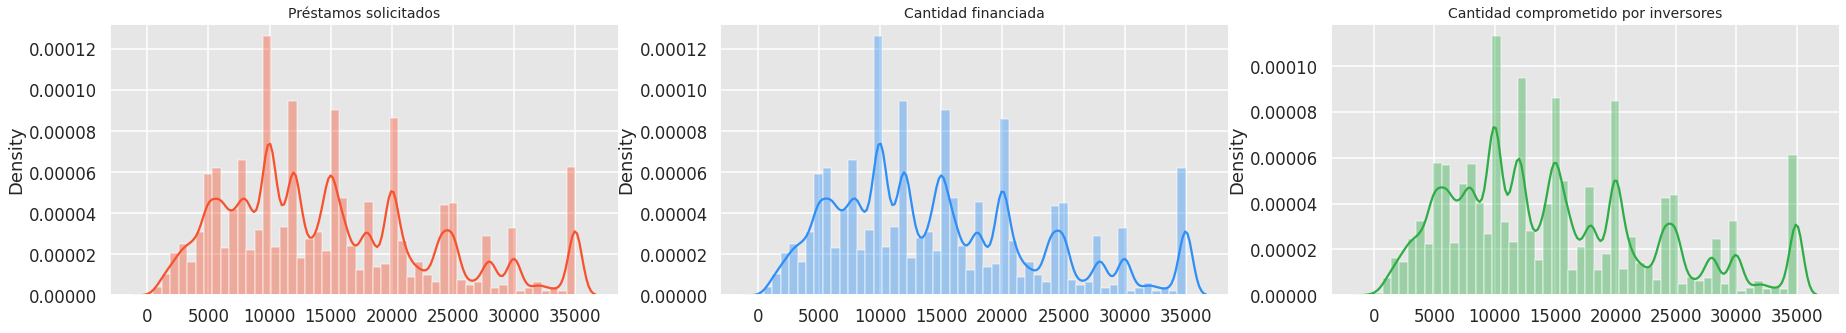

In [ ]:

fig, ax = plt.subplots(1, 3, figsize=(31,5))




loan_amount = df["loan_amnt"].values
funded_amount = df["funded_amnt"].values
investor_funds = df["funded_amnt_inv"].values


sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Préstamos solicitados", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Cantidad financiada", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Cantidad comprometido por inversores", fontsize=14)


In [ ]:
# Lets' transform the issue dates by year.
df['issue_d'].head()
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


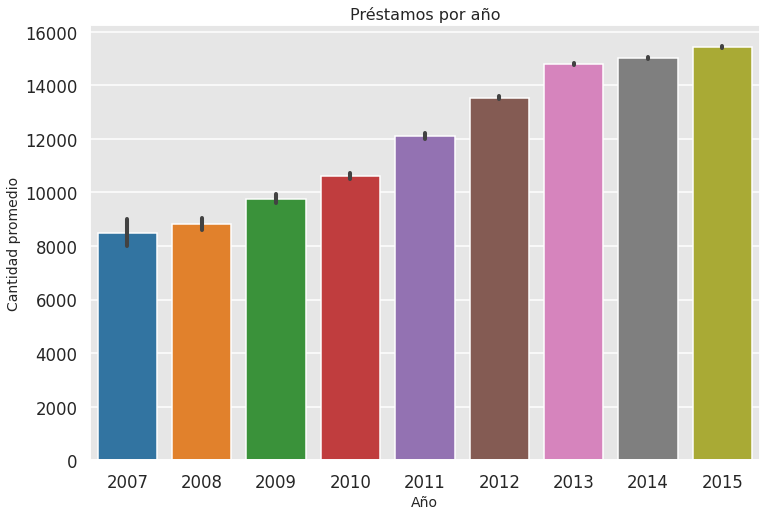

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amnt', data=df, palette='tab10')
plt.title('Préstamos por año', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Cantidad promedio', fontsize=14)
plt.savefig(ruta+'/imagenes/prestamos_año.png', bbox_inches='tight')

**Evaluando la variable "Title"**

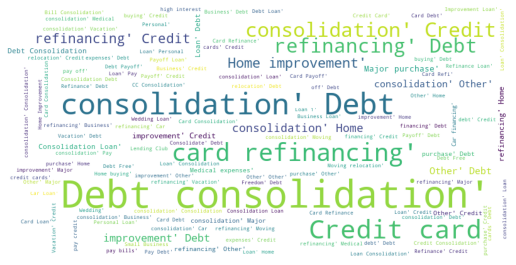

In [9]:
import nltk
import collections as co
from wordcloud import WordCloud, STOPWORDS

l = []
df['title'].apply(lambda x: l.append(x))
s=str(l)
plt.rcParams['figure.figsize'] = (9,6)


text = s

wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white', max_words=120, width=800, height=400).generate(text)

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig(ruta+'/imagenes/variale_title.png', bbox_inches='tight')
plt.show()

Evaluando la variable objetivo

In [ ]:
df["loan_status"].value_counts()

Current                                                566068
Fully Paid                                             197132
Charged Off                                             41779
Late (31-120 days)                                      10796
Issued                                                   7710
In Grace Period                                          5981
Late (16-30 days)                                        2194
Does not meet the credit policy. Status:Fully Paid       1877
Default                                                  1139
Does not meet the credit policy. Status:Charged Off       710
Name: loan_status, dtype: int64

Debemos crear una variable que sea binaria


In [ ]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

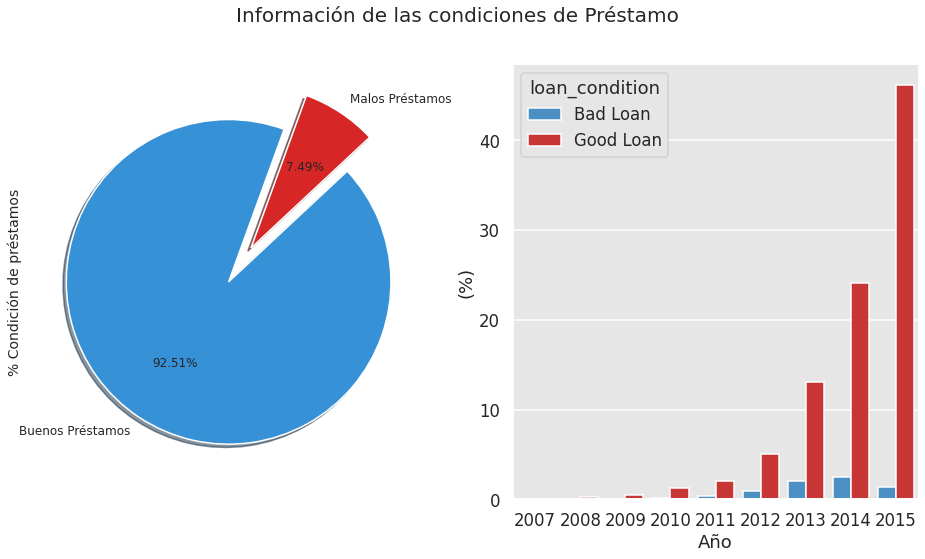

In [ ]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Buenos Préstamos", "Malos Préstamos"

plt.suptitle('Información de las condiciones de Préstamo', fontsize=20)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% Condición de préstamos', fontsize=14)

# sns.countplot('loan_condition', data=df, ax=ax[1], palette=colors)
# ax[1].set_title('Condition of Loans', fontsize=20)
# ax[1].set_xticklabels(['Good', 'Bad'], rotation='horizontal')
palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="year", y="loan_amnt", hue="loan_condition", data=df, palette=palette, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")
ax[1].set(xlabel="Año")
plt.savefig(ruta+'/imagenes/resumen_target.png', bbox_inches='tight')

Creación de algunas variables importantes

In [ ]:
df['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    


df['region'] = df['addr_state'].apply(finding_regions)
# This code will take the current date and transform it into a year-month format
df['complete_date'] = pd.to_datetime(df['issue_d'])


employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [df]
df['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0
    
# Let's create categories for annual_income since most of the bad loans are located below 100k   
df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_inc'] <= 100000, 'income_category'] = 'Baja'
    col.loc[(col['annual_inc'] > 100000) & (col['annual_inc'] <= 200000), 'income_category'] = 'Media'
    col.loc[col['annual_inc'] > 200000, 'income_category'] = 'Alta'

# Let's transform the column loan_condition into integrers.

lst = [df]
df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label)  
df['loan_condition_int'] = df['loan_condition_int'].astype(int)
##########################################################

# Average interest is 13.26% Anything above this will be considered of high risk let's see if this is true.
df['interest_payments'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['int_rate'] <= 13.23, 'interest_payments'] = 'Low'
    col.loc[col['int_rate'] > 13.23, 'interest_payments'] = 'High'
    

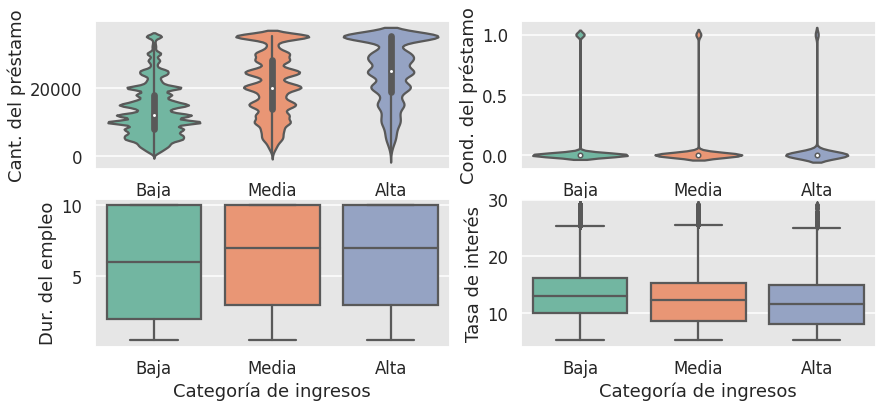

In [ ]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,6))

# Change the Palette types tomorrow!

sns.violinplot(x="income_category", y="loan_amnt", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_condition_int", data=df, palette="Set2", ax=ax2)
sns.boxplot(x="income_category", y="emp_length_int", data=df, palette="Set2", ax=ax3)
sns.boxplot(x="income_category", y="int_rate", data=df, palette="Set2", ax=ax4)
ax1.set_ylabel('Cant. del préstamo')
ax2.set_ylabel('Cond. del préstamo')
ax3.set_ylabel('Dur. del empleo')
ax4.set_ylabel('Tasa de interés')
ax4.set_xlabel('Categoría de ingresos')
ax3.set_xlabel('Categoría de ingresos')

plt.savefig(ruta+'/imagenes/estadisticas_dinero_gana.png', bbox_inches='tight')

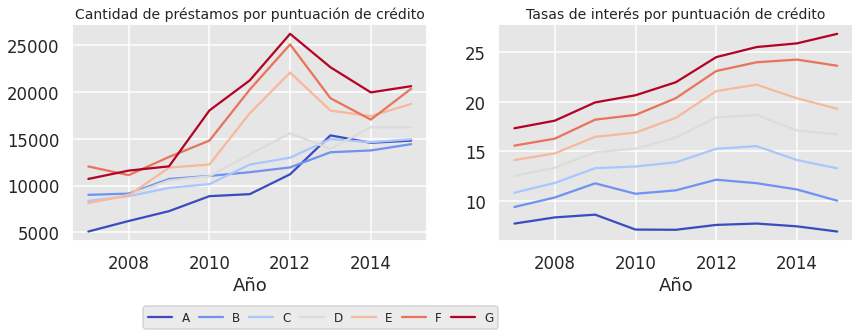

In [ ]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amnt.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Cantidad de préstamos por puntuación de crédito', fontsize=14)
ax1.set_xlabel('Año')
    
by_inc = df.groupby(['year', 'grade']).int_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Tasas de interés por puntuación de crédito', fontsize=14)
ax2.set_xlabel('Año')
ax2.legend(bbox_to_anchor=(-1.0, -0.4, 1.0, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)
plt.savefig(ruta+'/imagenes/prestamos_por_puntuacion.png', bbox_inches='tight')

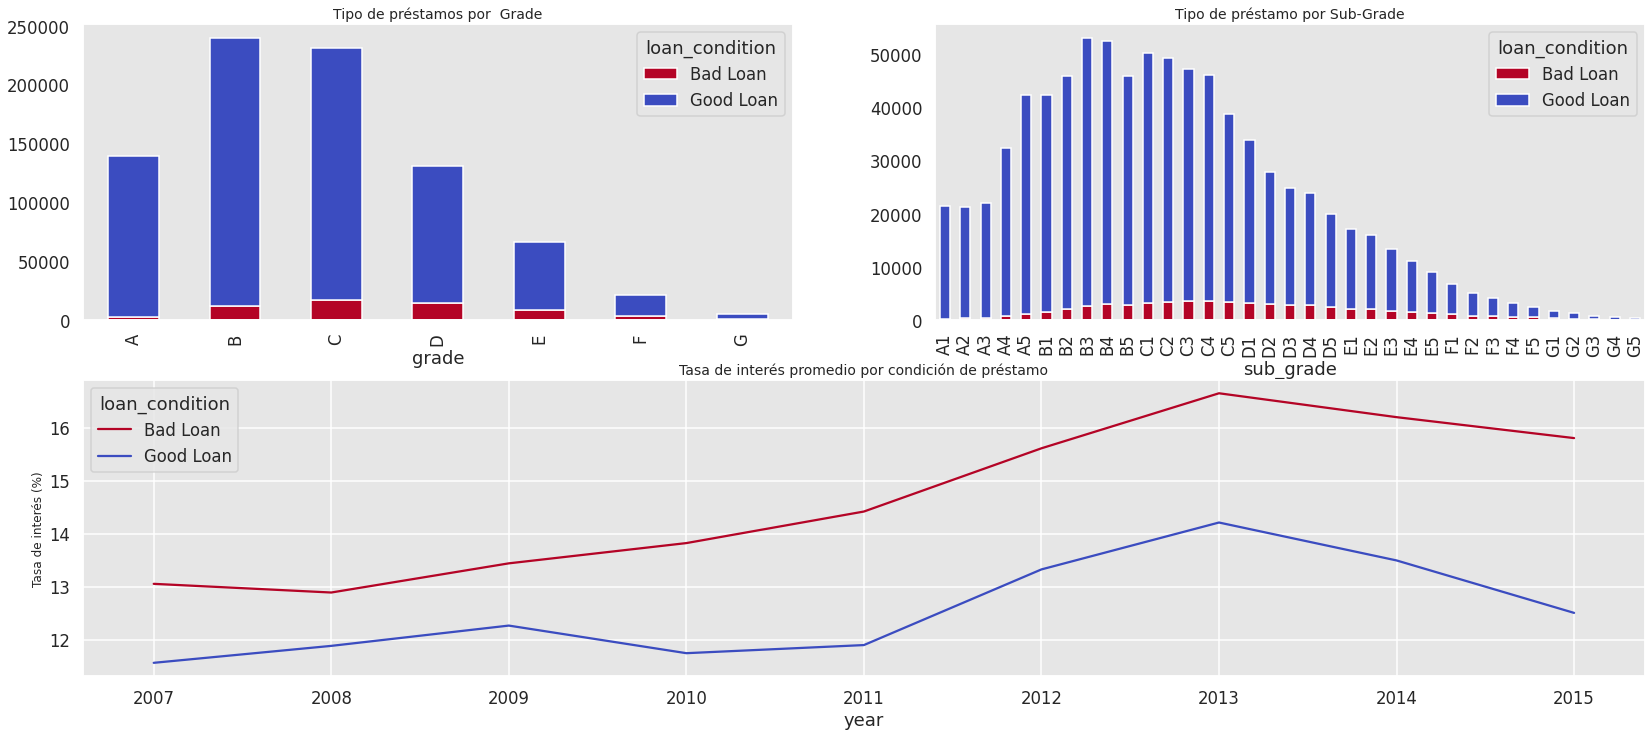

In [ ]:
fig = plt.figure(figsize=(28,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Tipo de préstamos por  Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Tipo de préstamo por Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_condition']).int_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Tasa de interés promedio por condición de préstamo', fontsize=14)
ax3.set_ylabel('Tasa de interés (%)', fontsize=12)
plt.savefig(ruta+'/imagenes/prestamos_por_puntuacion_2.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


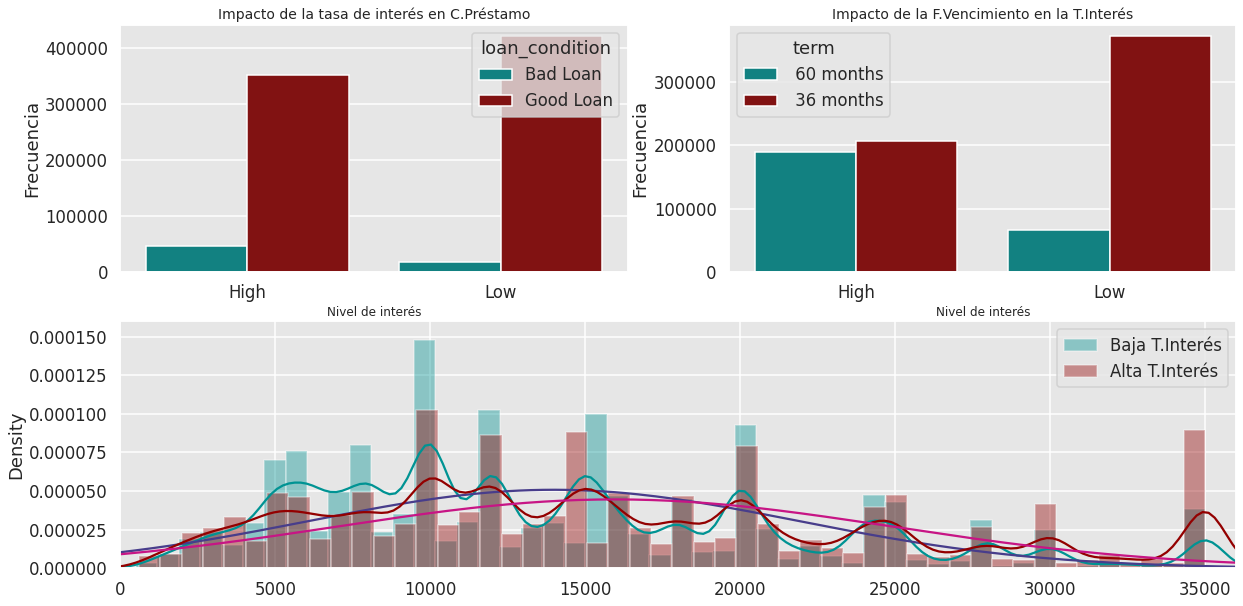

In [ ]:
from scipy.stats import norm

plt.figure(figsize=(20,10))

palette = ['#009393', '#930000']
plt.subplot(221)
ax = sns.countplot(x='interest_payments', data=df, 
                  palette=palette, hue='loan_condition')

ax.set_title('Impacto de la tasa de interés en C.Préstamo', fontsize=14)
ax.set_xlabel('Nivel de interés', fontsize=12)
ax.set_ylabel('Frecuencia')

plt.subplot(222)
ax1 = sns.countplot(x='interest_payments', data=df, 
                   palette=palette, hue='term')

ax1.set_title('Impacto de la F.Vencimiento en la T.Interés', fontsize=14)
ax1.set_xlabel('Nivel de interés', fontsize=12)
ax1.set_ylabel('Frecuencia')


plt.subplot(212)
low = df['loan_amnt'].loc[df['interest_payments'] == 'Low'].values
high = df['loan_amnt'].loc[df['interest_payments'] == 'High'].values


ax2= sns.distplot(low, color='#009393', label='Baja T.Interés', fit=norm, fit_kws={"color":"#483d8b"}) # Dark Blue Norm Color
ax3 = sns.distplot(high, color='#930000', label='Alta T.Interés', fit=norm, fit_kws={"color":"#c71585"}) #  Red Norm Color
plt.axis([0, 36000, 0, 0.00016])
plt.legend()

plt.savefig(ruta+'/imagenes/impacto_tasa_int.png', bbox_inches='tight')
plt.show()

#Creación de variables


* Hay características que son redundantes (como se muestra al principio de este kernel en los subgrupos de distribución) que no tienen ningún efecto sobre la etiqueta "condición_de_préstamo", por lo que tenemos que eliminar estas características.

* Utilizar StrattifiedShuffleSplit para tener aproximadamente la misma proporción de préstamos malos en comparación con los buenos en los datos de entrenamiento y de prueba. Recuerde que más del 92% de los préstamos se consideran buenos, por lo que es importante tener esta misma proporción en los conjuntos de entrenamiento y de prueba.

* Escalar las características numéricas y codificar las características categóricas de nuestro marco de datos.



In [ ]:
# Copy Dataframe
complete_df = df.copy()


# Handling Missing Numeric Values

# Transform Missing Values for numeric dataframe
# Nevertheless check what these variables mean tomorrow in the morning.
for col in ('dti_joint', 'annual_inc_joint', 'il_util', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
           'open_il_24m', 'inq_last_12m', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
           'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq', 'total_bal_il', 'tot_coll_amt',
           'tot_cur_bal', 'total_rev_hi_lim', 'revol_util', 'collections_12_mths_ex_med', 'open_acc', 'inq_last_6mths',
           'verification_status_joint', 'acc_now_delinq'):
    complete_df[col] = complete_df[col].fillna(0)
    


# # Get the mode of next payment date and last payment date and the last date credit amount was pulled   
complete_df["next_pymnt_d"] = complete_df.groupby("region")["next_pymnt_d"].transform(lambda x: x.fillna(x.mode))
complete_df["last_pymnt_d"] = complete_df.groupby("region")["last_pymnt_d"].transform(lambda x: x.fillna(x.mode))
complete_df["last_credit_pull_d"] = complete_df.groupby("region")["last_credit_pull_d"].transform(lambda x: x.fillna(x.mode))
complete_df["earliest_cr_line"] = complete_df.groupby("region")["earliest_cr_line"].transform(lambda x: x.fillna(x.mode))
complete_df["emp_title"] = complete_df.groupby("region")["earliest_cr_line"].transform(lambda x: x.fillna(x.mode))


# # Get the mode on the number of accounts in which the client is delinquent
complete_df["pub_rec"] = complete_df.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))

# # Get the mean of the annual income depending in the region the client is located.
complete_df["annual_inc"] = complete_df.groupby("region")["annual_inc"].transform(lambda x: x.fillna(x.mean()))

# Get the mode of the  total number of credit lines the borrower has 
complete_df["total_acc"] = complete_df.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

# Mode of credit delinquencies in the past two years.
complete_df["delinq_2yrs"] = complete_df.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# Drop these variables before scaling but don't drop these when we perform feature engineering on missing values.
# Columns to delete or fix: earliest_cr_line, last_pymnt_d, next_pymnt_d, last_credit_pull_d, verification_status_joint

# ---->>>> Fix the problems shown during scaling with the columns above.

complete_df.drop(['title','emp_length','url','next_pymnt_d','emp_title','last_pymnt_d','last_credit_pull_d','earliest_cr_line','zip_code','loan_status','issue_d','desc', 'loan_condition', 'mths_since_last_major_derog', 'annual_inc_joint',
                  'dti_joint','verification_status_joint', 'open_acc_6m', 'open_il_6m',
                  'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
                  'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',   
                  'inq_fi',  'total_cu_tl', 'inq_last_12m',
                  'mths_since_last_delinq', 'mths_since_last_record', 'complete_date','member_id','collection_recovery_fee', 'out_prncp_inv',
                  'acc_now_delinq', 'total_rec_prncp','installment', 'funded_amnt'], axis=1, inplace=True)
complete_df.reset_index(inplace=True, drop=True)

**Medición de Colinialidad**

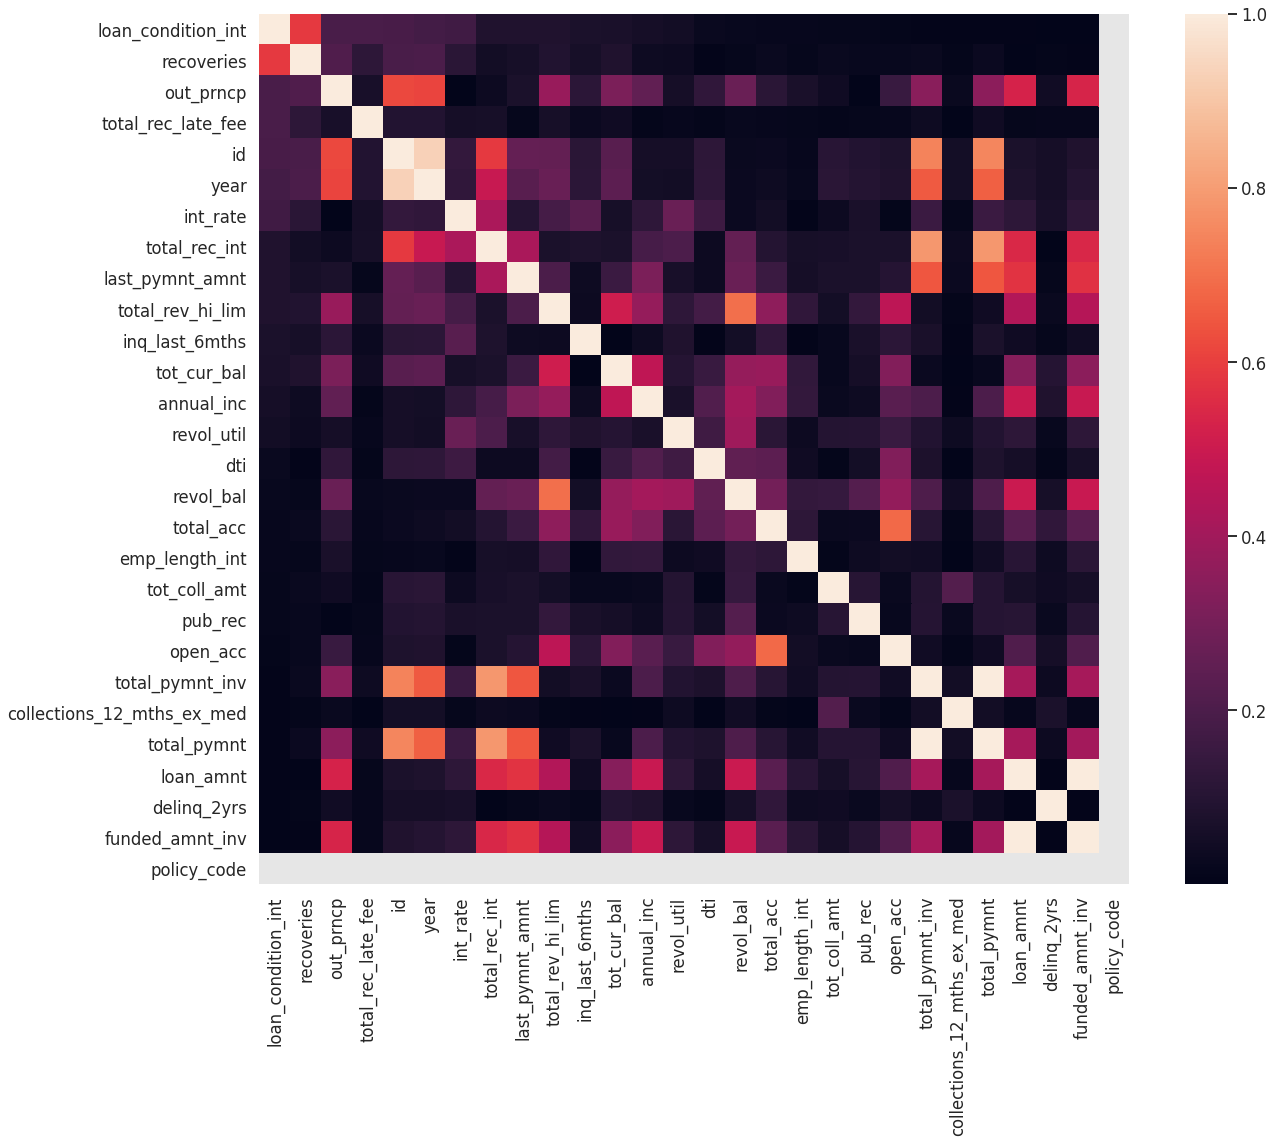

In [ ]:
# correlation between numeric variables
df_corr = complete_df.corr(method='spearman').abs()

# order columns and rows by correlation with SalePrice
df_corr = df_corr.sort_values('loan_condition_int',axis=0,ascending=False).sort_values('loan_condition_int',axis=1,ascending=False)



ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(df_corr,ax=ax,square=True)

verificar los valores perdidos

In [ ]:
complete_df.isnull().sum().max() # Maximum number of nulls.

0

In [ ]:
len(complete_df['loan_condition_int'])
# Loan Ratios (Imbalanced classes)
complete_df['loan_condition_int'].value_counts()/len(complete_df['loan_condition_int']) * 100

0    92.506578
1     7.493422
Name: loan_condition_int, dtype: float64

In [ ]:

stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(complete_df, complete_df["loan_condition_int"]):
    stratified_train = complete_df.loc[train_set]
    stratified_test = complete_df.loc[test_set]
    
print('Train set ratio \n', stratified_train["loan_condition_int"].value_counts()/len(df))
print('Test set ratio \n', stratified_test["loan_condition_int"].value_counts()/len(df))

Train set ratio 
 0    0.740052
1    0.059947
Name: loan_condition_int, dtype: float64
Test set ratio 
 0    0.185014
1    0.014987
Name: loan_condition_int, dtype: float64


In [ ]:
train_df = stratified_train
test_df = stratified_test


# Let's Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

for train_set, val_set in stratified.split(complete_df, complete_df["loan_condition_int"]):
    stratified_train = complete_df.loc[train_set]
    stratified_val = complete_df.loc[val_set]
    
print('Train set ratio \n', stratified_train["loan_condition_int"].value_counts()/len(df))
print('Val set ratio \n', stratified_val["loan_condition_int"].value_counts()/len(df))


Train set ratio 
 0    0.740052
1    0.059947
Name: loan_condition_int, dtype: float64
Val set ratio 
 0    0.185014
1    0.014987
Name: loan_condition_int, dtype: float64


In [ ]:
val_df = stratified_val

# Train set (Normal training dataset)
X_train = train_df.drop('loan_condition_int', axis=1)
y_train = train_df['loan_condition_int']


# Test Dataset
X_test = test_df.drop('loan_condition_int', axis=1)
y_test = test_df['loan_condition_int']

# Val Dataset
X_val = val_df.drop('loan_condition_int', axis=1)
y_val = val_df['loan_condition_int']

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

# Columns to delete or fix: earliest_cr_line, last_pymnt_d, next_pymnt_d, last_credit_pull_d, verification_status_joint

numeric = X_train.select_dtypes(exclude=["object"])
categorical = X_train.select_dtypes(["object"])

numeric_pipeline = Pipeline([
    ('selector', DataFrameSelector(['id', 'loan_amnt', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'year',
       'emp_length_int'])),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(['term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'pymnt_plan', 'purpose', 
       'addr_state', 'initial_list_status', 'application_type', 'region',
       'income_category', 'interest_payments'])), # We will have to write the categorical columns manually and see if it works.
    ('encoder',OneHotEncoder(drop='first')),
])

# Combine both Pipelines into one array
combined_pipeline = FeatureUnion(transformer_list=[
    ('numeric_pipeline', numeric_pipeline),
    ('categorical_pipeline', categorical_pipeline)
])

X_train = combined_pipeline.fit_transform(X_train)
X_test = combined_pipeline.fit_transform(X_test)
X_val = combined_pipeline.fit_transform(X_val)

#Modelado

In [122]:
data = pd.read_csv('/content/drive/MyDrive/seminario_investigacion/data_preparada.csv')

In [11]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

X = data.drop('loan_status', axis=1)
y = data.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(316175, 78)
(79044, 78)
(79044,)


In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ALGORITMO SMOTE

In [12]:
# Oversampled Train Set (Goes after encoding and scaling!)
from imblearn.over_sampling import SMOTE

starting_time = time.time()
sm = SMOTE(sampling_strategy='minority', random_state=seed)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
ending_time = time.time()

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [ ]:
print("After Oversampling X_train:", X_train.shape)
print(" y Afeter Over sampling", y_train.shape)

After Oversampling X_train: (316175, 78)
 y Afeter Over sampling (316175,)


In [17]:
np.save(ruta+'X_train_sm', X_train_sm)
np.save(ruta+'y_train_sm', y_train_sm)

In [18]:
#Cargar

x_loaded = np.load(ruta+'X_train_sm.npy')
y_load = np.load(ruta+'y_train_sm.npy')

**Modelos Clásicos**
----------------------------------------------

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error, log_loss
import math
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        MSE = np.square(np.subtract(true,pred)).mean() 
        print("_______________________________________________")
        RMSE = math.sqrt(MSE)
        
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        print("_______________________________________________")
        print(f"RMSE: \n {RMSE}\n")
        print("_______________________________________________")
        print( f"ROC_AUC: \n{roc_auc_score(true, pred)}\n")
        print("_______________________________________________")
        print( f"Log_Loss: \n{log_loss(true, pred)}\n")

In [10]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32) 

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [50, 120, 200]
min_samples_split = [2, 5, 10]
max_depth = [4, 6,10]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]

params_grid = {
    'n_estimators': n_estimators,
    'min_samples_split': min_samples_split,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features
}

rf_clf = RandomForestClassifier()
rf_cv = RandomizedSearchCV(rf_clf, params_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_cv.fit(X_train_sm, y_train_sm)
best_params = rf_cv.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 22.0min finished


**Visualizamos los mejores paramétros escogidos por el modelo**

In [ ]:
best_params

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train_sm, y_train_sm)

#####################################3Guardar el modelo


filename = ruta+'random_forest.sav'
pickle.dump(rf_clf, open(filename, 'wb'))

**Predicciones**

In [49]:
#Cargando modelos
rf_clf = joblib.load(ruta+"random_forest.sav")

In [ ]:
#Conjunto de prueba
y_test_pred = rf_clf.predict(X_test)
print_score(y_test, y_test_pred, train=False)


Test Result:
Accuracy Score: 81.90%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.918355      0.529648     0.819      0.724001      0.842107
recall         0.850438      0.690164     0.819      0.770301      0.819000
f1-score       0.883093      0.599345     0.819      0.741219      0.827434
support    63539.000000  15505.000000     0.819  79044.000000  79044.000000
_______________________________________________
_______________________________________________
Confusion Matrix: 
 [[54036  9503]
 [ 4804 10701]]

_______________________________________________
RMSE: 
 0.4254414829827227

_______________________________________________
ROC_AUC: 
0.7703013882765947

_______________________________________________
Log_Loss: 
6.251630388851352



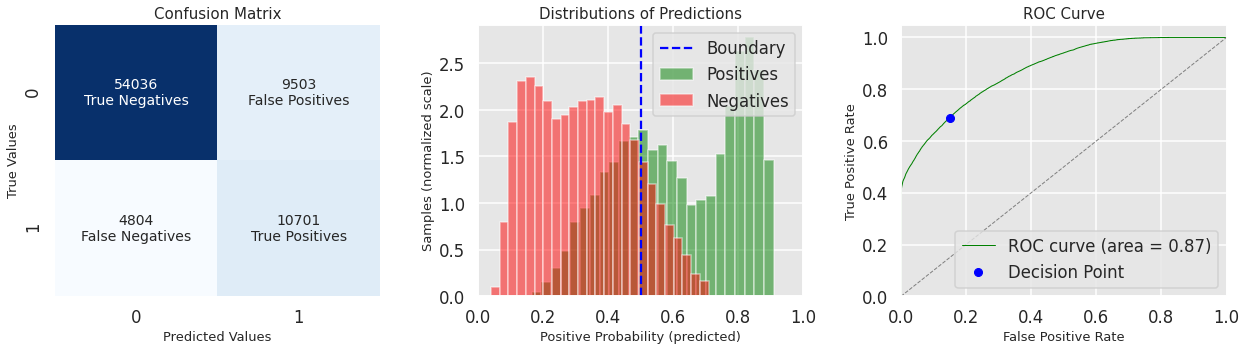

In [ ]:
evalBinaryClassifier(rf_clf, X_test,y_test)

**Creación del Dataframe de las métricas**

In [45]:
idx = ['Random Forest', 'Gradient Boosting', 'ElasticNet', 'D1', 'D2', 'D3', 'D4']
scores_models = pd.DataFrame(index= idx)

In [46]:

y_test_pred = rf_clf.predict(X_test)
scores_models.loc['Random Forest','Precision'] = precision_score(y_test, y_test_pred)
scores_models.loc['Random Forest','Recall'] = recall_score(y_test, y_test_pred)
scores_models.loc['Random Forest','ROC_AUC'] = roc_auc_score(y_test, y_test_pred)
scores_models.loc['Random Forest', 'F1_Score'] = f1_score(y_test, y_test_pred)
scores_models.loc['Random Forest', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred))
scores_models.loc['Random Forest', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [57]:
scores_models

,Precision,Recall,ROC_AUC,Log_Loss,F1_Score,RMSE,Accuracy
Random Forest,0.529648,0.690164,0.770301,6.25163,0.599345,0.425441,0.819
Gradient Boosting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ElasticNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Features importances RF**

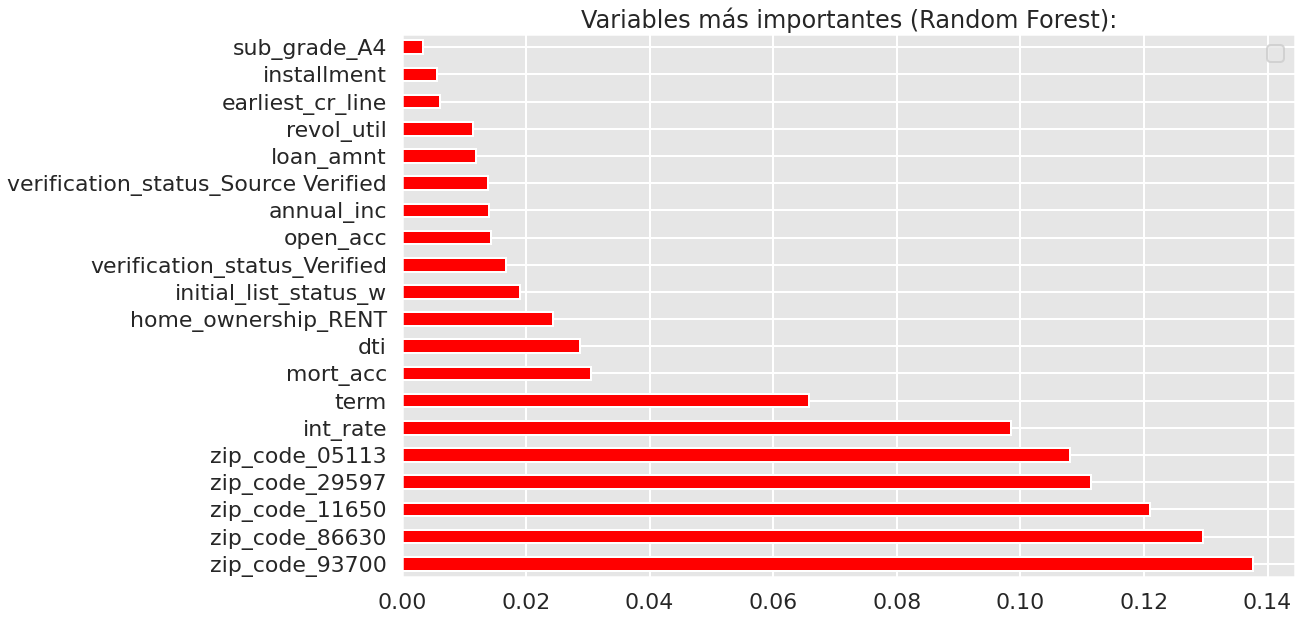

In [140]:
feat_importances = pd.DataFrame(rf_clf.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(by=0, ascending=False)[0:20]
feat_importances.plot(kind='barh', color='r', figsize=(16,10))
plt.title("Variables más importantes (Random Forest):")
plt.legend('')
plt.savefig(ruta+'/imagenes/rf_variables_importtantes.png', bbox_inches='tight')

Gradient Boosting

In [ ]:



n_estimators = [50, 100, 150]
learning_rate = [0.05, 0.01, 0.1, 0.3]
max_depth = [4, 6,8, 10]
subsample = [0.2, 0.5, 0.7]
max_features = ['auto', 'sqrt', 'log2']

gb_clf = GradientBoostingClassifier( random_state = seed, 
                                tol=0.01, n_iter_no_change=2)
params_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'subsample': subsample,
    'max_features': max_features
}

gb_cv = RandomizedSearchCV(gb_clf, params_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

gb_cv.fit(X_train_sm, y_train_sm)
best_params = gb_cv.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.2min finished


**Mejores paramétros para GB**

In [ ]:
best_paramns

{'learning_rate': 0.1,
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 100,
 'subsample': 0.2}

In [ ]:
gb_clf = GradientBoostingClassifier(**best_params)
gb_clf.fit(X_train_sm, y_train_sm)
###Saving

filename = ruta+'gradient_boosting.sav'
pickle.dump(gb_clf, open(filename, 'wb'))

**Predicciones**

In [118]:
#Cargando modelos
gb_clf = joblib.load(ruta+"gradient_boosting.sav")

In [ ]:
#Conjunto de prueba
y_test_pred = gb_clf.predict(X_test)

#print_score(y_train_sm, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Test Result:
Accuracy Score: 88.45%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.889401      0.847369   0.88452      0.868385      0.881156
recall         0.977951      0.501645   0.88452      0.739798      0.884520
f1-score       0.931576      0.630206   0.88452      0.780891      0.872460
support    63539.000000  15505.000000   0.88452  79044.000000  79044.000000
_______________________________________________
_______________________________________________
Confusion Matrix: 
 [[62138  1401]
 [ 7727  7778]]

_______________________________________________
RMSE: 
 0.33982346274304925

_______________________________________________
ROC_AUC: 
0.7397975904100703

_______________________________________________
Log_Loss: 
3.9885515810022834



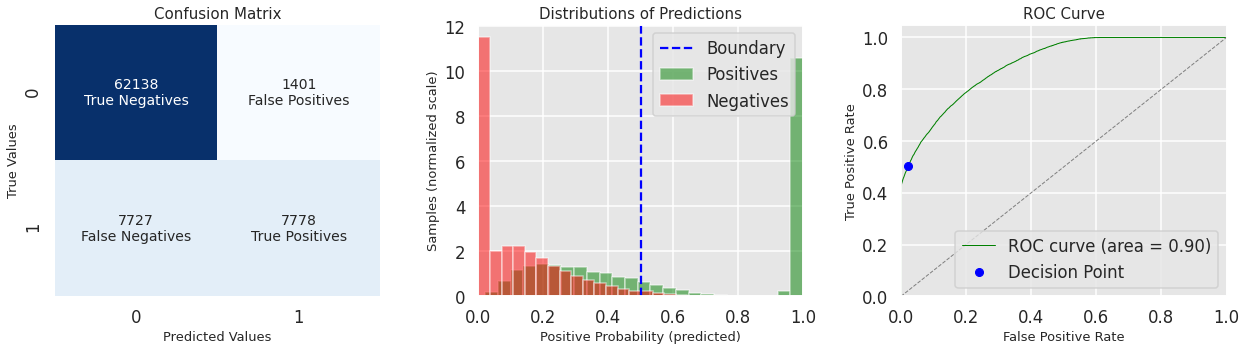

In [ ]:
evalBinaryClassifier(gb_clf, X_test,y_test)

In [48]:
y_test_pred = rf_clf.predict(X_test)
scores_models.loc['Gradient Boosting','Precision'] = precision_score(y_test, y_test_pred)
scores_models.loc['Gradient Boosting','Recall'] = recall_score(y_test, y_test_pred)
scores_models.loc['Gradient Boosting','ROC_AUC'] = roc_auc_score(y_test, y_test_pred)
scores_models.loc['Gradient Boosting', 'F1_Score'] = f1_score(y_test, y_test_pred)
scores_models.loc['Gradient Boosting', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred))
scores_models.loc['Gradient Boosting', 'Accuracy'] = accuracy_score(y_test, y_test_pred)


In [ ]:
scores_models

,Precision,Recall,ROC_AUC,Log_Loss,F1_Score,RMSE,Accuracy
Random Forest,0.529648,0.690164,0.770301,6.251630,0.599345,0.425441,0.81900
Gradient Boosting,0.847369,0.501645,0.739798,3.988552,0.630206,0.339823,0.88452
ElasticNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Feature importance GB**

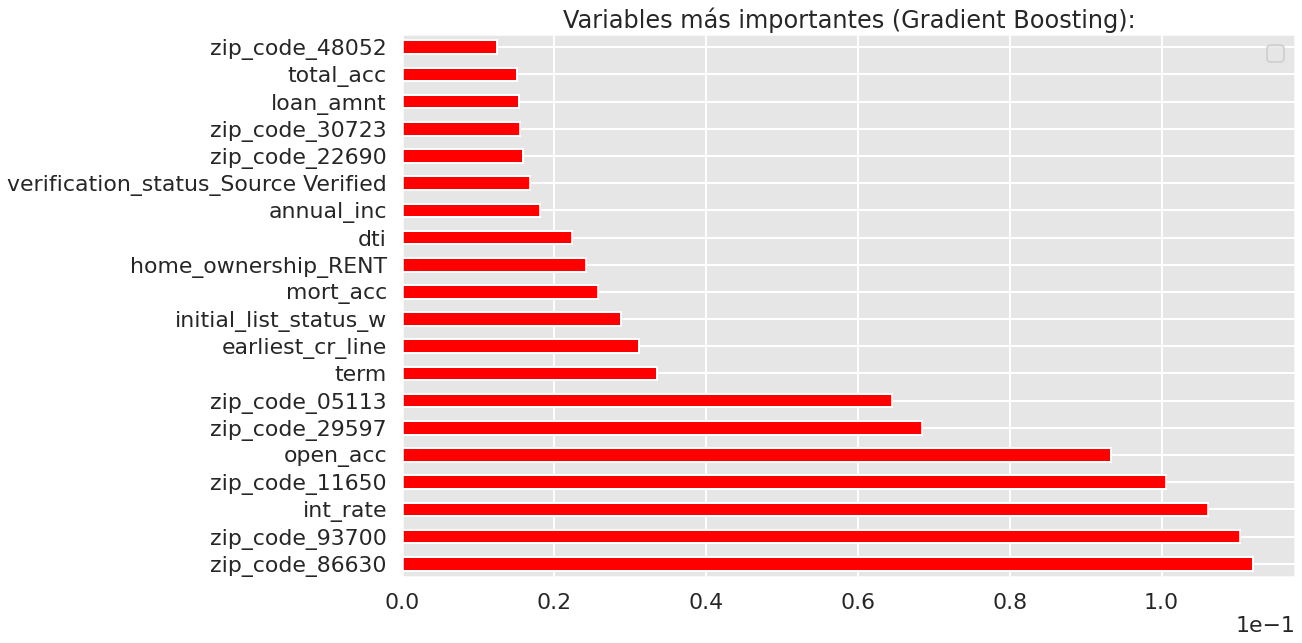

In [143]:
feat_importances = pd.DataFrame(gb_clf.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(by=0, ascending=False)[0:20]
feat_importances.plot(kind='barh', color='r', figsize=(16,10))
plt.title("Variables más importantes (Gradient Boosting):")
plt.legend('')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.savefig(ruta+'/imagenes/gb_variables_importtantes.png', bbox_inches='tight')

Elastic Net

In [ ]:
enet_clf=  LogisticRegression(penalty = 'elasticnet', random_state = seed)
l1_ratio = [0.5,0.6,0.1,0.05, 0.8]
C=[0.5, 0.7, 0.9, 1]
solver = [ 'saga']
params_grid = {
    'l1_ratio': l1_ratio,
    'C': C,
    'solver': solver,
  }

enet_cv = RandomizedSearchCV(enet_clf, params_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

enet_cv.fit(X_train_sm, y_train_sm)
best_params = enet_cv.best_params_

**Mejores paramétros para Elastic Net**

In [ ]:
enet_cv.best_params_

{'C': 1, 'l1_ratio': 0.1, 'solver': 'saga'}

**Guardando el modelo**

In [ ]:
enet_clf = LogisticRegression(**best_params,penalty = 'elasticnet', random_state = seed)
enet_clf.fit(X_train_sm, y_train_sm)
###Saving

filename = ruta+'elastic_net.sav'
pickle.dump(enet_clf, open(filename, 'wb'))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Predicciones**

In [176]:
#Cargando modelos
enet_clf = joblib.load(ruta+"elastic_net.sav")

In [ ]:
y_test_pred = enet_clf.predict(X_test)

#print_score(y_train_sm, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Test Result:
Accuracy Score: 79.98%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.942158      0.493642  0.799808      0.717900      0.854178
recall         0.800076      0.798710  0.799808      0.799393      0.799808
f1-score       0.865323      0.610169  0.799808      0.737746      0.815273
support    63539.000000  15505.000000  0.799808  79044.000000  79044.000000
_______________________________________________
_______________________________________________
Confusion Matrix: 
 [[50836 12703]
 [ 3121 12384]]

_______________________________________________
RMSE: 
 0.4474285395017058

_______________________________________________
ROC_AUC: 
0.7993928188361021

_______________________________________________
Log_Loss: 
6.914525516917445



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


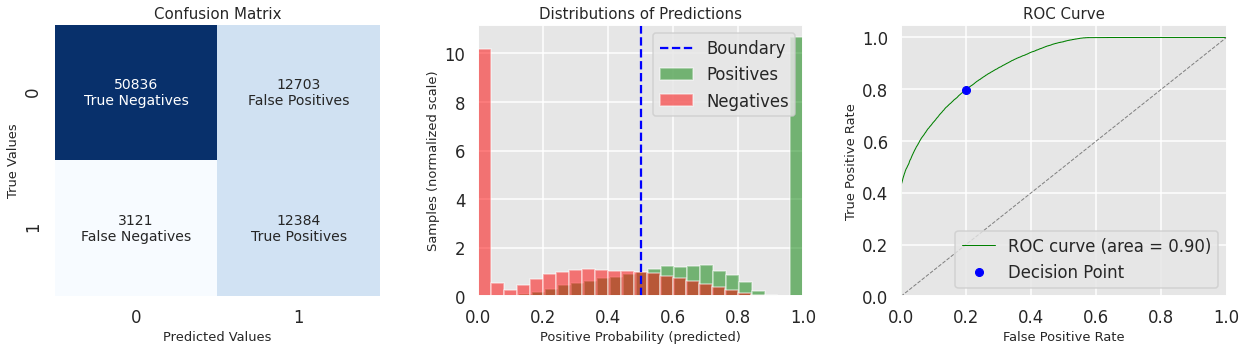

In [ ]:
evalBinaryClassifier(enet_clf, X_test,y_test)

In [50]:
y_test_pred = rf_clf.predict(X_test)
scores_models.loc['ElasticNet','Precision'] = precision_score(y_test, y_test_pred)
scores_models.loc['ElasticNet','Recall'] = recall_score(y_test, y_test_pred)
scores_models.loc['ElasticNet','ROC_AUC'] = roc_auc_score(y_test, y_test_pred)
scores_models.loc['ElasticNet', 'F1_Score'] = f1_score(y_test, y_test_pred)
scores_models.loc['ElasticNet', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred))
scores_models.loc['ElasticNet', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

**Feature importance**

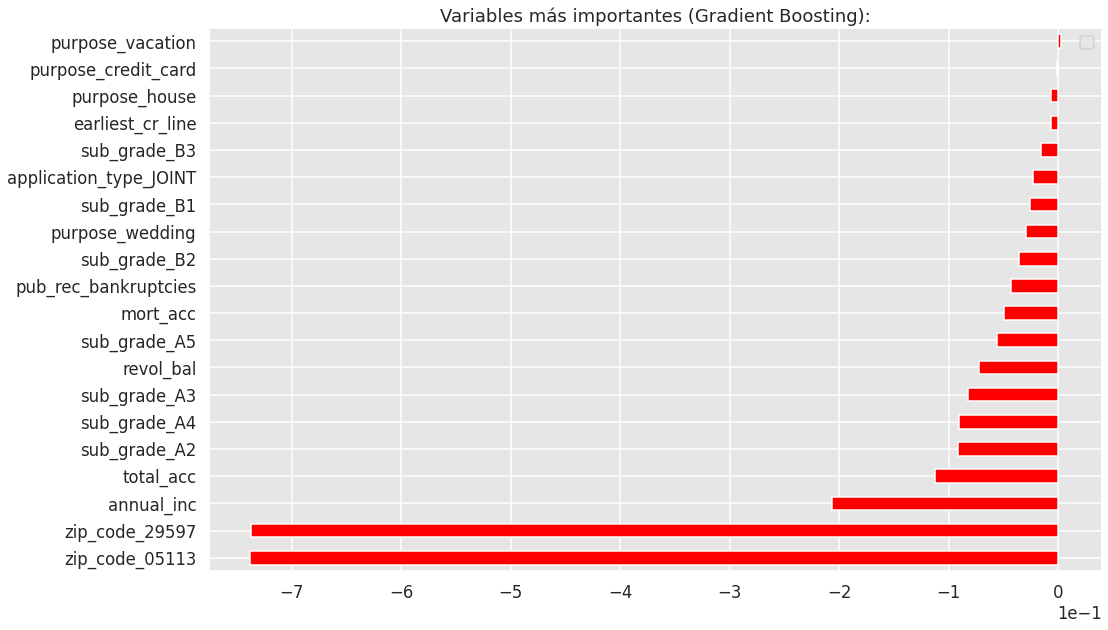

In [ ]:
feat_importances = pd.DataFrame(enet_clf.coef_[0], index=X.columns)
feat_importances = feat_importances.sort_values(by=0, ascending=True)[0:20]
feat_importances.plot(kind='barh', color='r', figsize=(16,10))
plt.title("Variables más importantes (Gradient Boosting):")
plt.legend('')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.savefig(ruta+'/imagenes/enet_variables_importtantes.png', bbox_inches='tight')

**Comparaciòn de AUC para modelos "Clasicos"**

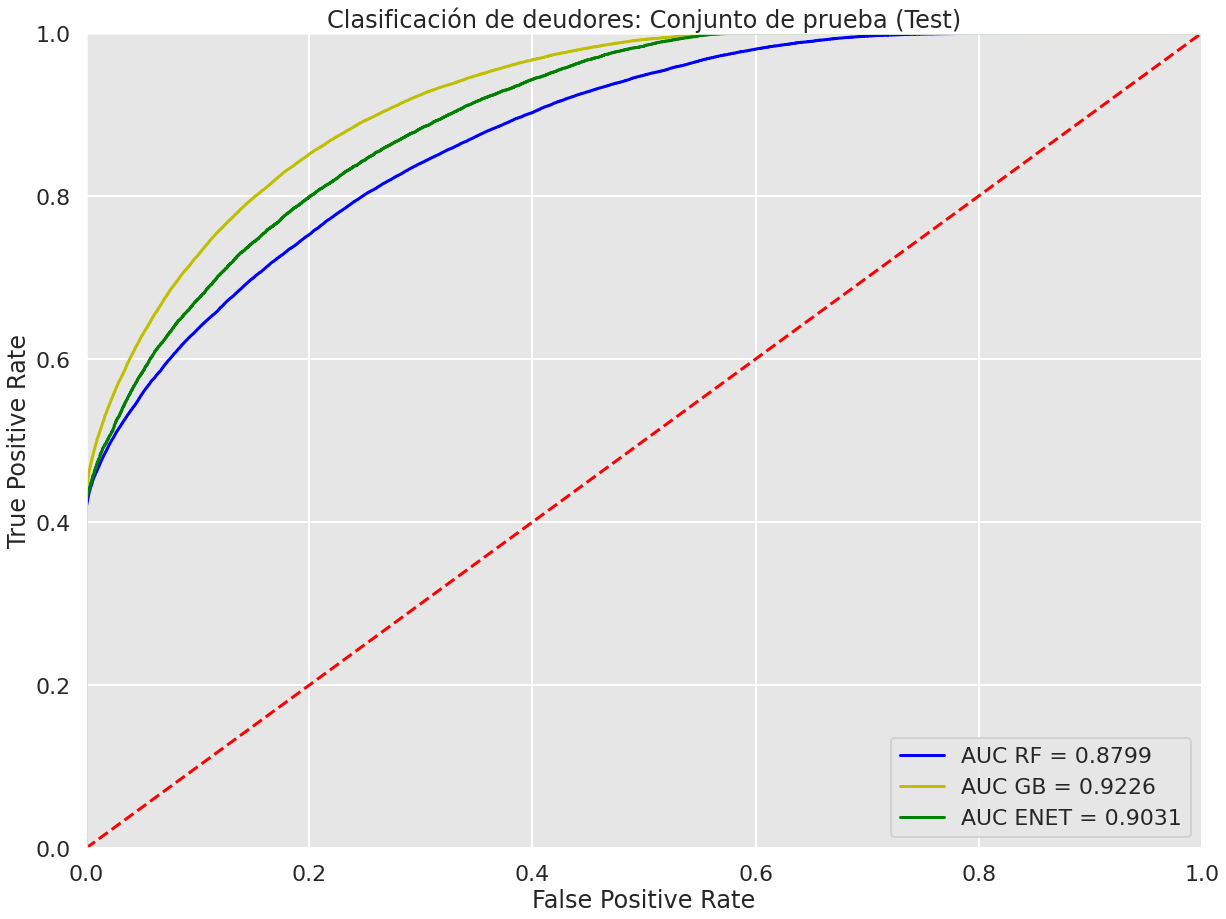

In [18]:
# calculate the fpr and tpr for all thresholds of the classification
fig = plt.figure(figsize=(20,15))

sns.set_context("poster")

probs = rf_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


probs0 = gb_clf.predict_proba(X_test)
preds0 = probs0[:,1]
fpr0, tpr0, threshold0 = roc_curve(y_test, preds0)
roc_auc0 = auc(fpr0, tpr0)

probs1 = enet_clf.predict_proba(X_test)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = roc_curve(y_test, preds1)
roc_auc1 = auc(fpr1, tpr1)

# method I: plt

plt.title('Clasificación de deudores: Conjunto de prueba (Test)')
plt.plot(fpr, tpr, 'b', label = 'AUC RF = %0.4f' % roc_auc)
plt.plot(fpr0, tpr0, 'y', label = 'AUC GB = %0.4f' % roc_auc0)
plt.plot(fpr1, tpr1, 'g', label = 'AUC ENET = %0.4f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(ruta+'/imagenes/auc_clasicos.png', bbox_inches='tight')

***Guardamos los dfs con la info de scores**

In [25]:
scores_models.to_csv(ruta+"scores_todas_features.csv", index=True)

#Modelos de Deep Leaning

(ANNS) ARTIFICIAL NN

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Recall, Precision, LogCoshError, Accuracy, RootMeanSquaredError, BinaryCrossentropy
from keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers, optimizers

**Modelo 1**
------------------------------------------

In [73]:
def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [74]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model1 = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model1.fit(
    X_train_sm, y_train_sm,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32
)

In [ ]:
# serialize model to JSON
model_json = model1.to_json()
with open(ruta+"ann_model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights(ruta+"ann_model1.h5")
print("Saved model to disk")

###Para cargarloo

#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

Saved model to disk


In [21]:
json_file = open(ruta+'ann_model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(ruta+"ann_model1.h5")
print("Loaded model from disk")

Loaded model from disk


In [22]:
model1 = loaded_model

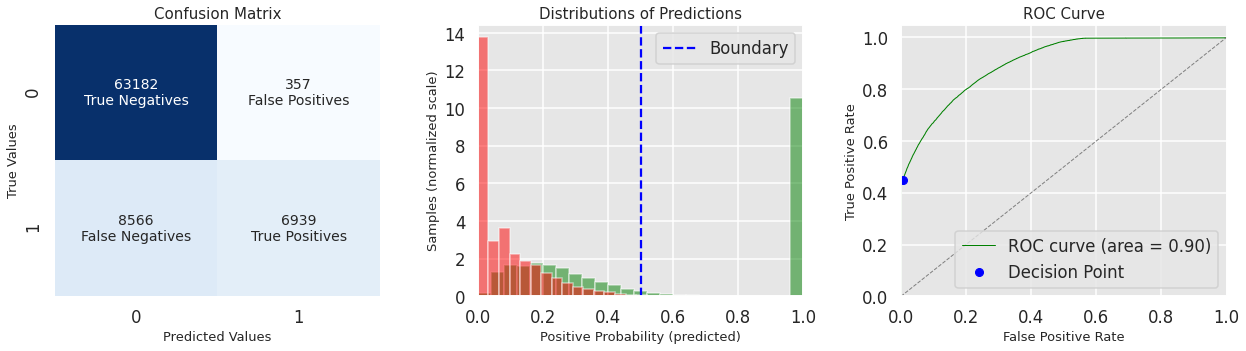

In [ ]:
evalBinaryClassifier_NN(model, X_test, y_test)

In [53]:
y_test_pred = model.predict(X_test)
scores_models.loc['D1','Precision'] = precision_score(y_test, y_test_pred.round())
scores_models.loc['D1','Recall'] = recall_score(y_test, y_test_pred.round())
scores_models.loc['D1','ROC_AUC'] = roc_auc_score(y_test, y_test_pred.round())
scores_models.loc['D1', 'F1_Score'] = f1_score(y_test, y_test_pred.round())
scores_models.loc['D1', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred.round()))
scores_models.loc['D1', 'Accuracy'] = accuracy_score(y_test, y_test_pred.round())

¿Cómo está aprendiendo nuestro modelo? **Shap Values**

In [48]:
explainer = shap.KernelExplainer(model, X_train_sm[:100])
shap_values = explainer.shap_values(X_test[:50])

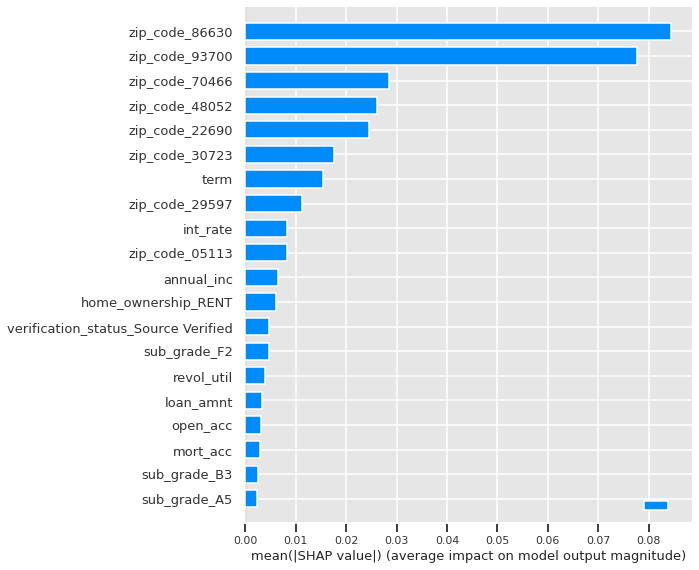

In [49]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=' ',title='Variables importantes para el modelo NN con Shapley Values')

**Segunda arquitectura de red neuronal**
---------------------------------------------------------------

In [26]:
#AQUI ESTAMSO ALMACENANDO LAS METRICAS
scores_models = pd.read_csv(ruta+"scores_todas_features.csv")

In [75]:
model2 = Sequential()

# input layer
model2.add(Dense(78,activation='relu'))
model2.add(Dropout(0.2))

# hidden layer
model2.add(Dense(39,activation='relu'))
model2.add(Dropout(0.2))

# hidden layer
model2.add(Dense(19,activation='relu'))
model2.add(Dropout(0.2))

# output layer
model2.add(Dense(1, activation='sigmoid'))

# compile model
model2.compile(optimizer="adam", loss='binary_crossentropy')

In [76]:
#Regularización adicional del modelo

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [28]:
model2.fit(x=X_train_sm, 
          y=y_train_sm, 
          epochs=15,
          verbose = 2,
          batch_size=32,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])

Epoch 1/15
15885/15885 - 23s - loss: 0.3658 - val_loss: 0.3419
Epoch 2/15
15885/15885 - 22s - loss: 0.3481 - val_loss: 0.3535
Epoch 3/15
15885/15885 - 22s - loss: 0.3432 - val_loss: 0.3451
Epoch 4/15
15885/15885 - 22s - loss: 0.3394 - val_loss: 0.3437
Epoch 5/15
15885/15885 - 22s - loss: 0.3350 - val_loss: 0.3386
Epoch 6/15
15885/15885 - 22s - loss: 0.3303 - val_loss: 0.3495
Epoch 7/15
15885/15885 - 22s - loss: 0.3265 - val_loss: 0.3248
Epoch 8/15
15885/15885 - 22s - loss: 0.3222 - val_loss: 0.3256
Epoch 9/15
15885/15885 - 22s - loss: 0.3188 - val_loss: 0.3279
Epoch 10/15
15885/15885 - 22s - loss: 0.3160 - val_loss: 0.3281
Epoch 11/15
15885/15885 - 22s - loss: 0.3141 - val_loss: 0.3506
Epoch 12/15
15885/15885 - 22s - loss: 0.3122 - val_loss: 0.3184
Epoch 13/15
15885/15885 - 22s - loss: 0.3111 - val_loss: 0.3169
Epoch 14/15
15885/15885 - 23s - loss: 0.3095 - val_loss: 0.3095
Epoch 15/15
15885/15885 - 22s - loss: 0.3082 - val_loss: 0.3300


In [30]:
model_json = model2.to_json()
with open(ruta+"ann_model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights(ruta+"ann_model2.h5")
print("Saved model to disk")

Saved model to disk


**Cargando el modelo**

In [23]:
json_file = open(ruta+'ann_model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(ruta+"ann_model2.h5")
print("Loaded model from disk")
model2 =loaded_model

Loaded model from disk


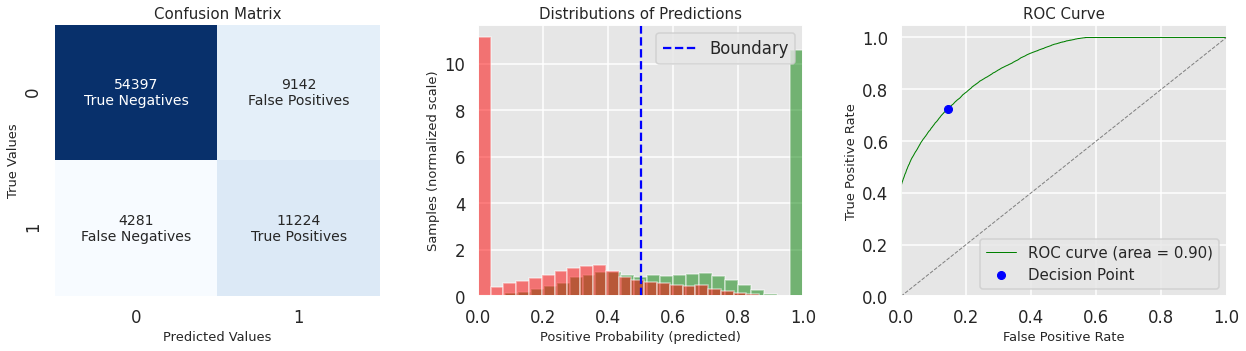

In [51]:
evalBinaryClassifier_NN(model, X_test, y_test)

**Variables importantes con Shap**

In [ ]:
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, X_train_sm[:50000])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:500])

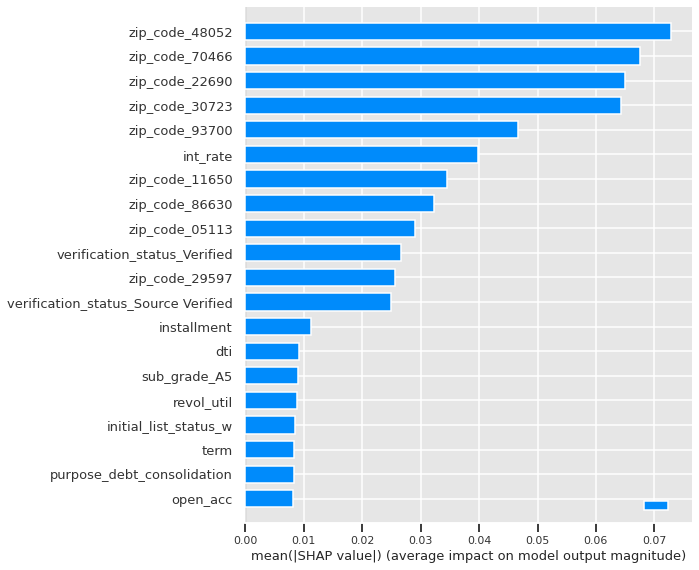

In [126]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=' ',title='Variables importantes para el modelo NN con Shapley Values')

In [55]:
y_test_pred = model.predict(X_test)

scores_models.loc['D2','Precision'] = precision_score(y_test, y_test_pred.round())
scores_models.loc['D2','Recall'] = recall_score(y_test, y_test_pred.round())
scores_models.loc['D2','ROC_AUC'] = roc_auc_score(y_test, y_test_pred.round())
scores_models.loc['D2', 'F1_Score'] = f1_score(y_test, y_test_pred.round())
scores_models.loc['D2', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred.round()))
scores_models.loc['D2', 'Accuracy'] = accuracy_score(y_test, y_test_pred.round())

In [69]:
scores_models

,Precision,Recall,ROC_AUC,F1_Score,RMSE,Accuracy
Random Forest,0.529648,0.690164,0.770301,0.599345,0.425441,0.819000
Gradient Boosting,0.529648,0.690164,0.770301,0.599345,0.425441,0.819000
ElasticNet,0.529648,0.690164,0.770301,0.599345,0.425441,0.819000
D1,0.951069,0.447533,0.720957,0.608658,0.335986,0.887114
D2,0.551115,0.723896,0.790008,0.625798,0.412088,0.830183
D3,NaN,NaN,NaN,NaN,NaN,NaN
D4,NaN,NaN,NaN,NaN,NaN,NaN


Tercera arquitectira de red neuronal
--------------------------------------

In [77]:
model3 = Sequential()

# input layer
model3.add(Dense(78,activation='relu',))
model3.add(Dropout(0.5))

# hidden layer
model3.add(Dense(59,activation='softmax',))
model3.add(Dropout(0.5))


# hidden layer
model3.add(Dense(39,activation='relu', kernel_regularizer='l1_l2'))
model3.add(Dropout(0.2))

# hidden layer
model3.add(Dense(29,activation='relu'))
model3.add(Dropout(0.3))

# hidden layer
model3.add(Dense(19,activation='relu'))
model3.add(Dropout(0.2))

# output layer
model3.add(Dense(1, activation='sigmoid'))


# compile model
model3.compile(optimizer="adam", loss='binary_crossentropy')

In [38]:
model3.fit(x=X_train_sm, 
          y=y_train_sm, 
          epochs=15,
          verbose = 2,
          batch_size=32,)

Epoch 1/15
15885/15885 - 27s - loss: 0.4889
Epoch 2/15
15885/15885 - 26s - loss: 0.4281
Epoch 3/15
15885/15885 - 26s - loss: 0.4210
Epoch 4/15
15885/15885 - 26s - loss: 0.4199
Epoch 5/15
15885/15885 - 26s - loss: 0.4262
Epoch 6/15
15885/15885 - 25s - loss: 0.4271
Epoch 7/15
15885/15885 - 25s - loss: 0.4269
Epoch 8/15
15885/15885 - 26s - loss: 0.4276
Epoch 9/15
15885/15885 - 26s - loss: 0.4268
Epoch 10/15
15885/15885 - 25s - loss: 0.4257
Epoch 11/15
15885/15885 - 26s - loss: 0.4232
Epoch 12/15
15885/15885 - 26s - loss: 0.4213
Epoch 13/15
15885/15885 - 26s - loss: 0.4220
Epoch 14/15
15885/15885 - 26s - loss: 0.4222
Epoch 15/15
15885/15885 - 26s - loss: 0.4209


In [40]:
model_json = model3.to_json()
with open(ruta+"ann_model3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model3.save_weights(ruta+"ann_model3.h5")
print("Saved model to disk")

Saved model to disk


**Cargando el modelo**

In [25]:
json_file = open(ruta+'ann_model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(ruta+"ann_model3.h5")
print("Loaded model from disk")
model3 =loaded_model

Loaded model from disk


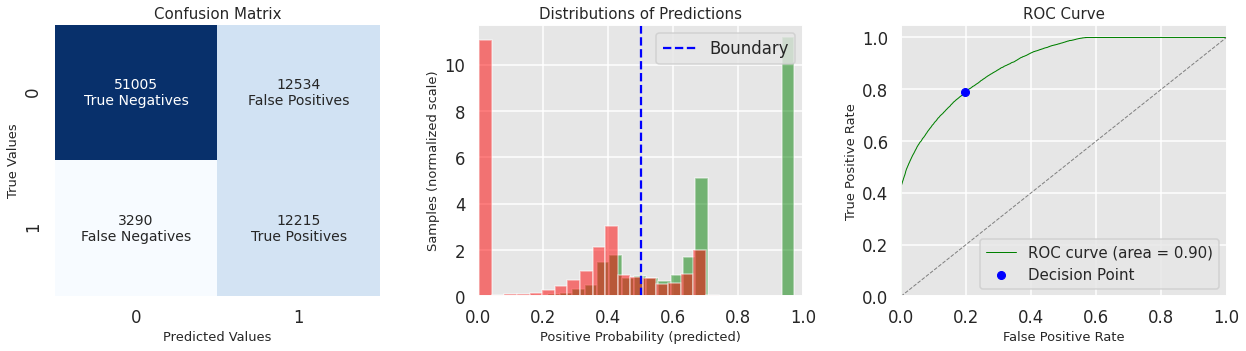

In [39]:
evalBinaryClassifier_NN(model1, X_test, y_test)

In [56]:
y_test_pred = model1.predict(X_test)

scores_models.loc['D3','Precision'] = precision_score(y_test, y_test_pred.round())
scores_models.loc['D3','Recall'] = recall_score(y_test, y_test_pred.round())
scores_models.loc['D3','ROC_AUC'] = roc_auc_score(y_test, y_test_pred.round())
scores_models.loc['D3', 'F1_Score'] = f1_score(y_test, y_test_pred.round())
scores_models.loc['D3', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred.round()))
scores_models.loc['D3', 'Accuracy'] = accuracy_score(y_test, y_test_pred.round())

¿Cómo está aprendiendo el modelo? **Shap**

In [58]:
explainer = shap.KernelExplainer(model1, X_train_sm[:100])
shap_values = explainer.shap_values(X_test[:50])

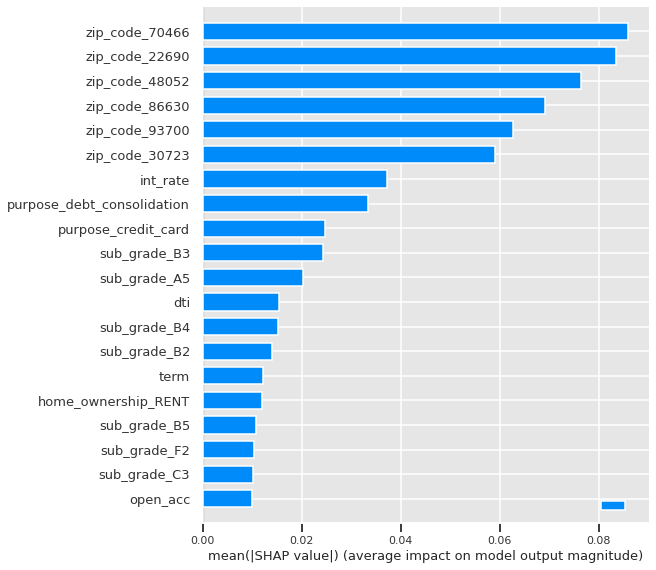

In [59]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=' ',title='Variables importantes para el modelo NN con Shapley Values')

**Cuarta Arqutectura**
-------------------------------------

In [78]:
model4 = Sequential()

# input layer
model4.add(Dense(78,  activation='tanh',))


# hidden layer
model4.add(Dense(70, activation='tanh', kernel_initializer='uniform'))
model4.add(Dropout(0.3))

# hidden layer
model4.add(Dense(45, activation='tanh', kernel_initializer='uniform', ))
model4.add(Dropout(0.3))




# hidden layer
model4.add(Dense(35, activation='tanh'))
model4.add(Dropout(0.2))


# hidden layer
model4.add(Dense(25, activation='tanh'))
model4.add(Dropout(0.2))

# hidden layer
model4.add(Dense(15, activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model4.add(Dropout(0.1))


# output layer
model4.add(Dense(units=1,activation='sigmoid'))

opt = optimizers.Adam(learning_rate=0.03)
# Compile model
model4.compile(loss='binary_crossentropy', optimizer=opt)
#Regularización adicional del modelo

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [93]:
model4.fit(x=X_train_sm, 
          y=y_train_sm, 
          epochs=8
           ,
          verbose = 2,
          batch_size=32,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])

Epoch 1/8
15885/15885 - 30s - loss: 0.5236 - val_loss: 0.5360
Epoch 2/8
15885/15885 - 28s - loss: 0.5456 - val_loss: 0.4927
Epoch 3/8
15885/15885 - 28s - loss: 0.5493 - val_loss: 0.4846
Epoch 4/8
15885/15885 - 28s - loss: 0.5522 - val_loss: 0.4968
Epoch 5/8
15885/15885 - 28s - loss: 0.5526 - val_loss: 0.5550
Epoch 6/8
15885/15885 - 28s - loss: 0.5540 - val_loss: 0.4598
Epoch 7/8
15885/15885 - 28s - loss: 0.5556 - val_loss: 0.5389
Epoch 8/8
15885/15885 - 31s - loss: 0.5553 - val_loss: 0.5171


In [103]:
model_json = model3.to_json()
with open(ruta+"ann_model4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model3.save_weights(ruta+"ann_model4.h5")
print("Saved model to disk")

Saved model to disk


**Cargando el modelo**

In [26]:
json_file = open(ruta+'ann_model4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(ruta+"ann_model4.h5")
print("Loaded model from disk")
model4 =loaded_model

Loaded model from disk


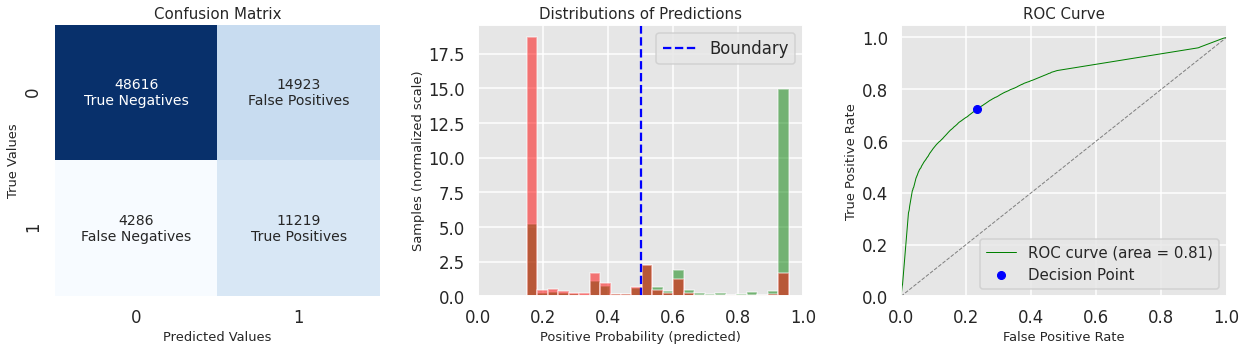

In [95]:
evalBinaryClassifier_NN(model3, X_test, y_test)

**¿Còmo está aprendiendo el modelo?*** Shap

In [101]:
explainer = shap.KernelExplainer(model3, X_train_sm[:100])
shap_values = explainer.shap_values(X_test[:50])

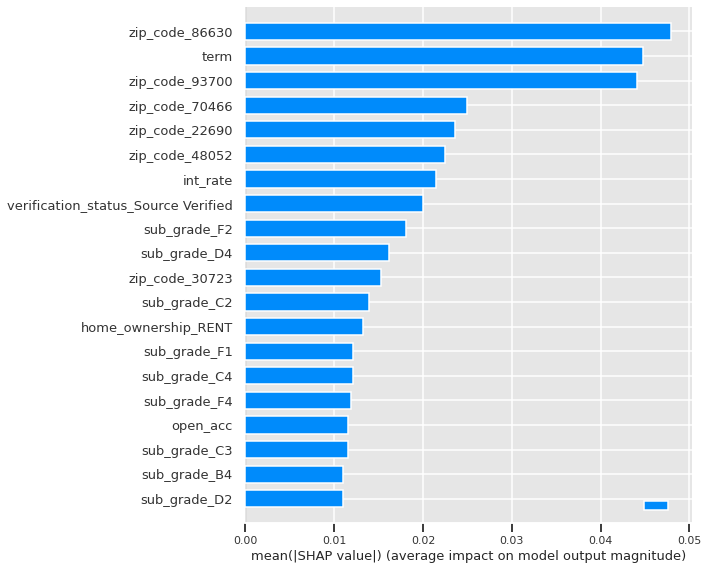

In [102]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=' ',title='Variables importantes para el modelo NN con Shapley Values')

In [96]:
y_test_pred = model3.predict(X_test)

scores_models.loc['D4','Precision'] = precision_score(y_test, y_test_pred.round())
scores_models.loc['D4','Recall'] = recall_score(y_test, y_test_pred.round())
scores_models.loc['D4','ROC_AUC'] = roc_auc_score(y_test, y_test_pred.round())
scores_models.loc['D4', 'F1_Score'] = f1_score(y_test, y_test_pred.round())
scores_models.loc['D4', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred.round()))
scores_models.loc['D4', 'Accuracy'] = accuracy_score(y_test, y_test_pred.round())

In [98]:
scores_models.reset_index(inplace=True)

In [99]:
scores_models.to_csv(ruta+"scores_todas_features.csv", index=True)

**Resultados Finales de los modelos**

**Esto junto con las curvas roc y las variales importantes es lo que debemos mostrar en la presentaciòn**

In [175]:
scores_models

,index,Precision,Recall,ROC_AUC,F1_Score,RMSE,Accuracy
0,Random Forest,0.529648,0.690164,0.770301,0.599345,0.425441,0.819000
1,Gradient Boosting,0.529648,0.690164,0.770301,0.599345,0.425441,0.819000
2,ElasticNet,0.529648,0.690164,0.770301,0.599345,0.425441,0.819000
3,D1,0.951069,0.447533,0.720957,0.608658,0.335986,0.887114
4,D2,0.551115,0.723896,0.790008,0.625798,0.412088,0.830183
5,D3,0.493555,0.787810,0.795273,0.606896,0.447429,0.799808
6,D4,0.429156,0.723573,0.744355,0.538766,0.492967,0.756983


In [38]:
scores_model.to_csv(ruta+"scores_todas_features_copy.csv", index=False)

In [104]:
scores_model = pd.read_csv(ruta+"scores_todas_features.csv")
scores_model = scores_model.rename(columns={'index':'Modelo'})
scores_model = scores_model.drop(['Unnamed: 0'], axis=1)

In [110]:
scores_model.set_index('Modelo', inplace=True)

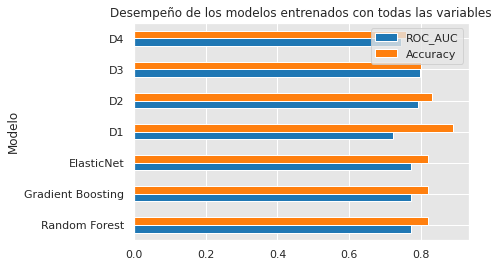

In [115]:
scores_model[['ROC_AUC','Accuracy']].plot( kind='barh', )
plt.title('Desempeño de los modelos entrenados con todas las variables')
plt.legend(loc='upper right')
plt.savefig(ruta+'/imagenes/accuracy_por_modelo_todas_variables.png', bbox_inches='tight')

**Mediciòn del desempeño midiendo el AUC**

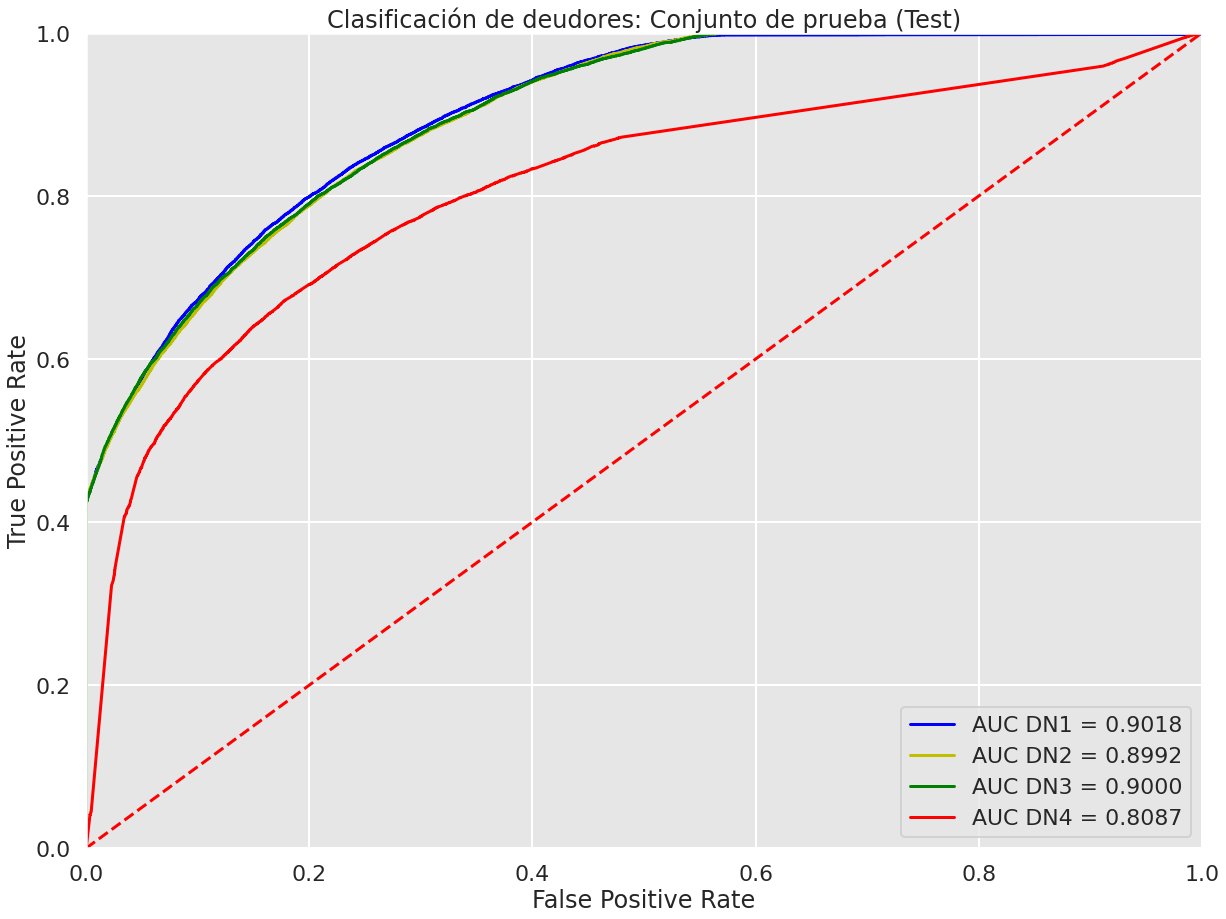

In [28]:
# calculate the fpr and tpr for all thresholds of the classification
fig = plt.figure(figsize=(20,15))

sns.set_context("poster")

probs =model1.predict(X_test)
preds = probs
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


probs0 = model2.predict(X_test)
preds0 = probs0
fpr0, tpr0, threshold0 = roc_curve(y_test, preds0)
roc_auc0 = auc(fpr0, tpr0)

probs1 = model3.predict(X_test)
preds1 = probs1
fpr1, tpr1, threshold1 = roc_curve(y_test, preds1)
roc_auc1 = auc(fpr1, tpr1)


probs2 = model4.predict(X_test)
preds2 = probs2
fpr2, tpr2, threshold2 = roc_curve(y_test, preds2)
roc_auc2 = auc(fpr2, tpr2)

# method I: plt

plt.title('Clasificación de deudores: Conjunto de prueba (Test)')
plt.plot(fpr, tpr, 'b', label = 'AUC DN1 = %0.4f' % roc_auc)
plt.plot(fpr0, tpr0, 'y', label = 'AUC DN2 = %0.4f' % roc_auc0)
plt.plot(fpr1, tpr1, 'g', label = 'AUC DN3 = %0.4f' % roc_auc1)
plt.plot(fpr2, tpr2, 'R', label = 'AUC DN4 = %0.4f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(ruta+'/imagenes/auc_deep.png', bbox_inches='tight')

#Medicion de estabilidad de los algoritmos

**Solo vamos a entrenar los algoritmos con las 10 caracteristicas más importantes de los modelos RF, GB y Eleastic Net y así medimos su estabilidad**

***Entrenando los 7 modelos con las 10 variables mas importantes de RF**

**Top 10 VARIABLES**
--------------------------------------------

In [177]:
X = data.drop('loan_status', axis=1)
y = data.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(316175, 78)
(79044, 78)
(79044,)


In [179]:
#feat_importances = pd.DataFrame(enet_clf.feature_importances_, index=X.columns)
#feat_importances = feat_importances.sort_values(by=0, ascending=False)[0:20]

feat_importances = pd.DataFrame(enet_clf.coef_[0], index=X.columns)
feat_importances = feat_importances.sort_values(by=0, ascending=False)[0:20]
feat_importances.reset_index(inplace=True)
feat_importances= feat_importances.rename(columns={'index':'variable'})
top10_rf = feat_importances.loc[0:10, 'variable'].tolist()

In [186]:
idx = ['Random Forest', 'Gradient Boosting', 'ElasticNet', 'D1', 'D2', 'D3', 'D4']
scores_models = pd.DataFrame(index= idx)

In [197]:
rf_clf = RandomForestClassifier()

gb_clf = GradientBoostingClassifier(random_state = seed, tol=0.01, n_iter_no_change=2,)


enet_clf=  LogisticRegression( penalty='elasticnet', solver='saga',l1_ratio=0.4)

In [188]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

X = data.drop('loan_status', axis=1)
X= X[top10_rf]
y = data.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)

(316175, 11)
(79044, 11)
(79044,)


In [189]:
# Oversampled Train Set (Goes after encoding and scaling!)
from imblearn.over_sampling import SMOTE

starting_time = time.time()
sm = SMOTE(sampling_strategy='minority', random_state=seed)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
ending_time = time.time()

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [190]:
rf_clf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [191]:
y_test_pred = rf_clf.predict(X_test)
scores_models.loc['Random Forest','Precision'] = precision_score(y_test, y_test_pred)
scores_models.loc['Random Forest','Recall'] = recall_score(y_test, y_test_pred)
scores_models.loc['Random Forest','ROC_AUC'] = roc_auc_score(y_test, y_test_pred)
scores_models.loc['Random Forest', 'F1_Score'] = f1_score(y_test, y_test_pred)
scores_models.loc['Random Forest', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred))
scores_models.loc['Random Forest', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

--------------------------------------

In [192]:
gb_clf.fit(X_train_sm, y_train_sm)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=2, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.01,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [193]:
y_test_pred = gb_clf.predict(X_test)
scores_models.loc['Gradient Boosting','Precision'] = precision_score(y_test, y_test_pred)
scores_models.loc['Gradient Boosting','Recall'] = recall_score(y_test, y_test_pred)
scores_models.loc['Gradient Boosting','ROC_AUC'] = roc_auc_score(y_test, y_test_pred)
scores_models.loc['Gradient Boosting', 'F1_Score'] = f1_score(y_test, y_test_pred)
scores_models.loc['Gradient Boosting', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred))
scores_models.loc['Gradient Boosting', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

-----------------------------------------------------------------------------------------------------

In [198]:
enet_clf.fit(X_train_sm, y_train_sm)

The max_iter was reached which means the coef_ did not converge


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.4, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [199]:
y_test_pred = enet_clf.predict(X_test)
scores_models.loc['ElasticNet','Precision'] = precision_score(y_test, y_test_pred)
scores_models.loc['ElasticNet','Recall'] = recall_score(y_test, y_test_pred)
scores_models.loc['ElasticNet','ROC_AUC'] = roc_auc_score(y_test, y_test_pred)
scores_models.loc['ElasticNet', 'F1_Score'] = f1_score(y_test, y_test_pred)
scores_models.loc['ElasticNet', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred))
scores_models.loc['ElasticNet', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [200]:
scores_models

,Precision,Recall,ROC_AUC,F1_Score,RMSE,Accuracy
Random Forest,0.313922,0.554531,0.629396,0.400895,0.570184,0.674890
Gradient Boosting,1.000000,0.276556,0.638278,0.433284,0.376707,0.858092
ElasticNet,0.220104,0.860755,0.558252,0.350565,0.790933,0.374424
D1,NaN,NaN,NaN,NaN,NaN,NaN
D2,NaN,NaN,NaN,NaN,NaN,NaN
D3,NaN,NaN,NaN,NaN,NaN,NaN
D4,NaN,NaN,NaN,NaN,NaN,NaN


DEEEP LEARNING -----------------------------

Model 1 D1:

In [ ]:
r = model1.fit(
    X_train_sm, y_train_sm,
    validation_data=(X_test, y_test),
    epochs=7,
    batch_size=32
)

Epoch 1/7
15885/15885 [==============================] - 80s 5ms/step - loss: 0.4541 - AUC: 0.8409 - val_loss: 1120.2727 - val_AUC: 0.5000
Epoch 2/7
15885/15885 [==============================] - 80s 5ms/step - loss: 0.4424 - AUC: 0.8485 - val_loss: 66366.0469 - val_AUC: 0.5000
Epoch 3/7
15885/15885 [==============================] - 79s 5ms/step - loss: 0.4377 - AUC: 0.8525 - val_loss: 91196.0469 - val_AUC: 0.5000
Epoch 4/7
15885/15885 [==============================] - 79s 5ms/step - loss: 0.4369 - AUC: 0.8530 - val_loss: 79869.6172 - val_AUC: 0.5000
Epoch 5/7
 1263/15885 [=>............................] - ETA: 1:09 - loss: 0.4379 - AUC: 0.8525

In [ ]:
y_test_pred = model1.predict(X_test)
scores_models.loc['D1','Precision'] = precision_score(y_test, y_test_pred.round())
scores_models.loc['D1','Recall'] = recall_score(y_test, y_test_pred.round())
scores_models.loc['D1','ROC_AUC'] = roc_auc_score(y_test, y_test_pred.round())
scores_models.loc['D1', 'F1_Score'] = f1_score(y_test, y_test_pred.round())
scores_models.loc['D1', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred.round()))
scores_models.loc['D1', 'Accuracy'] = accuracy_score(y_test, y_test_pred.round())

----------------------------------------------------

In [ ]:
model2.fit(x=X_train_sm, 
          y=y_train_sm, 
          epochs=7,
          verbose = 2,
          batch_size=32,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])

In [ ]:
y_test_pred = model2.predict(X_test)
scores_models.loc['D2','Precision'] = precision_score(y_test, y_test_pred.round())
scores_models.loc['D2','Recall'] = recall_score(y_test, y_test_pred.round())
scores_models.loc['D2','ROC_AUC'] = roc_auc_score(y_test, y_test_pred.round())
scores_models.loc['D2', 'F1_Score'] = f1_score(y_test, y_test_pred.round())
scores_models.loc['D2', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred.round()))
scores_models.loc['D2', 'Accuracy'] = accuracy_score(y_test, y_test_pred.round())

----------------------------------------------------------------------------------------------------------


In [ ]:
model3.fit(x=X_train_sm, 
          y=y_train_sm, 
          epochs=7,
          verbose = 2,
          batch_size=32,)

In [ ]:
y_test_pred = model3.predict(X_test)
scores_models.loc['D3','Precision'] = precision_score(y_test, y_test_pred.round())
scores_models.loc['D3','Recall'] = recall_score(y_test, y_test_pred.round())
scores_models.loc['D3','ROC_AUC'] = roc_auc_score(y_test, y_test_pred.round())
scores_models.loc['D3', 'F1_Score'] = f1_score(y_test, y_test_pred.round())
scores_models.loc['D3', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred.round()))
scores_models.loc['D3', 'Accuracy'] = accuracy_score(y_test, y_test_pred.round())

-------------------------------------------------------------------------

In [ ]:
model4.fit(x=X_train_sm, 
          y=y_train_sm, 
          epochs=7
           ,
          verbose = 2,
          batch_size=32,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])

In [ ]:
y_test_pred = model4.predict(X_test)
scores_models.loc['D4','Precision'] = precision_score(y_test, y_test_pred.round())
scores_models.loc['D4','Recall'] = recall_score(y_test, y_test_pred.round())
scores_models.loc['D4','ROC_AUC'] = roc_auc_score(y_test, y_test_pred.round())
scores_models.loc['D4', 'F1_Score'] = f1_score(y_test, y_test_pred.round())
scores_models.loc['D4', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred.round()))
scores_models.loc['D4', 'Accuracy'] = accuracy_score(y_test, y_test_pred.round())

**Dataframe de top 10 Random Forest**

In [172]:
scores_models

,Precision,Recall,ROC_AUC,F1_Score,RMSE,Accuracy
Random Forest,0.315000,0.616124,0.644588,0.416870,0.581477,0.661885
Gradient Boosting,0.315281,0.612770,0.644012,0.416345,0.580519,0.662998
ElasticNet,0.581972,0.252757,0.604227,0.352444,0.426837,0.817810
D1,0.196157,1.000000,0.500000,0.327978,0.896573,0.196157
D2,0.196157,1.000000,0.500000,0.327978,0.896573,0.196157
D3,0.196157,1.000000,0.500000,0.327978,0.896573,0.196157
D4,0.000000,0.000000,0.500000,0.000000,0.442896,0.803843


In [ ]:
scores_models

In [182]:
scores_models.reset_index(inplace=True)
scores_models = scores_models.rename(columns={'index':'Modelo'})
scores_models.to_csv(ruta+"scores_GB_top10.csv", index=False)

In [174]:
scores_models.set_index("Modelo", inplace=True)

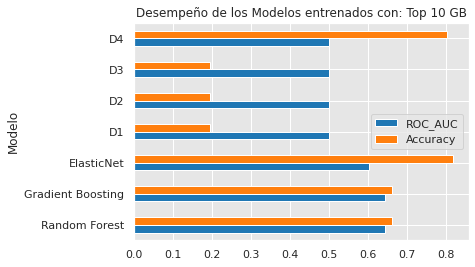

In [181]:
sns.set_context("notebook")
scores_models[['ROC_AUC','Accuracy']].plot(kind='barh')
plt.title("Desempeño de los Modelos entrenados con: Top 10 GB")
plt.savefig(ruta+'/imagenes/desempeño_por_modelo_10_GB.png', bbox_inches='tight')